In [1]:
using Random
using DataStructures
using Plots
using Statistics
using Combinatorics

using NBInclude
@nbinclude("dcj_algo.ipynb")
@nbinclude("testing_diameter.ipynb")
# @nbinclude("testing_maps.ipynb")

In [2]:
# returns dup char --> num instances dictionary, num of duplicate chars  
##### returns 2 x N array (N = num dup char) of duplicate char & num instances, num of duplicate chars

function find_dups_in_str(str::String)
    alphabet = Set{Char}() 
    duplicates = OrderedDict{Char, Int}()  # duplicate char --> num instances 

    for char in str
        if char == '.' || char == ','
            continue 
        end 
        
        char = lowercase(char)   
        if char in alphabet 
            if char in keys(duplicates)
                duplicates[char] += 1
            else 
                duplicates[char] = 2 
            end 
        else 
            push!(alphabet, char)
        end 
    end 

    return duplicates, length(duplicates) 
end 

find_dups_in_str (generic function with 1 method)

In [3]:
function generate_map(num_dups::Int, dup_to_num_instances::OrderedDict{Char, Int}, S_M_set::Set{Array{Int}})
    while true 
        map = Array{Int}(undef, num_dups)
        
        idx = 1
        # for each position of the map (each gene w >1 instances)
        for (dup_char, num_instances) in pairs(dup_to_num_instances)
            # an integer value is selcted uniformly from the interval [0, occ(α, S)! -1] 
            mapidx_for_dup_char = rand(1:factorial(num_instances))
            
            map[idx] = mapidx_for_dup_char
            idx += 1
        end 
        if map ∉ S_M_set
            return map 
        end 
    end 
end 

# S = "aabc"
# S_dupchar_to_multiplicity, S_num_dups = find_dups_in_str(S)
# S_M_set = Set{Array{Int}}()
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
# push!(S_M_set, map)
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
# push!(S_M_set, map)
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set) # should throw error bc alr generated all possible maps

generate_map (generic function with 1 method)

In [5]:
function new_char(alphabet::Set{Char})
    while length(alphabet) != 26 
        c = Char(rand('a':'z'))
        if c ∉ alphabet 
            push!(alphabet, c)
            return c
        end 
    end 
    throw(ArgumentError("Ran out of unique characters in the alphabet"))
    
end 


function deduplicate_genome(map::Array{Int}, dup_genome::String, dupchar_to_multiplicity::OrderedDict{Char, Int}, dupchar_to_unique_chars::OrderedDict{Char, Vector{Char}})
    if dupchar_to_unique_chars == OrderedDict{Char, Vector{Char}}()  # passed in target genome; need to assign dup chars to unique chars
        alphabet = Set(dup_genome)
        
        # create mapping from duplicated chars (multiplicity k) --> [array of k unique chars], idx = idx of duplicate (referenced by permutation) 
        idx = 1
        for (dupchar, mult) in pairs(dupchar_to_multiplicity)
            unique_chars = [dupchar]
            for i in 2:dupchar_to_multiplicity[dupchar]
                c = new_char(alphabet)
                push!(unique_chars, c)
            end     
            dupchar_to_unique_chars[dupchar] = unique_chars
            
            idx += 1
        end 
    end 

    # for each duplicated char, create the correct ordering of unique chars in deduplicated genome 
    # based on mapping from dup chars -> unique chars & lexicographical permutation
    idx = 1
    dup_char_to_mapped_unique_chars = Dict{Char, Vector{Char}}()
    for (dupchar, unique_chars) in pairs(dupchar_to_unique_chars)
        # for each elem i in map, convert i --> ith permutation of k ints in lexicographical order (k = multiplicity)
        dup_char_to_mapped_unique_chars[dupchar] = nthperm(unique_chars, map[idx])  
        
        idx += 1
    end 

    # deduplicate the genome with the orderings generated above with the permutations for duplicate genes
    dedup_genome = Vector{Char}()
    for char in dup_genome
        
        if lowercase(char) in keys(dupchar_to_multiplicity)
            unique_char = dup_char_to_mapped_unique_chars[lowercase(char)][1]
            if isuppercase(char) 
                unique_char = uppercase(unique_char)
            end 
            push!(dedup_genome, unique_char)

            splice!(dup_char_to_mapped_unique_chars[lowercase(char)], 1)
        else 
            push!(dedup_genome, char)
        end 
    end

    return join(dedup_genome)
end 



# P = "abbAac"
# P_dup_to_num_instances, P_num_dups = find_dups_in_str(P)
# P_map = generate_map(P_num_dups, P_dup_to_num_instances, Set{Array{Int64}}())
# dupchar_to_unique_char = OrderedDict{Char, Vector{Char}}()

# deduplicate_genome(P_map, P, P_dup_to_num_instances, dupchar_to_unique_char)

"pbyAhc"

In [6]:
function linear_circ_helper(src_chroms::Vector{SubString{String}}) 
    linear_chroms = Vector{String}() 
    circ_chroms = Vector{String}()
    linear_idx_to_genome_idx = Dict{Int, Int}() 
    circ_idx_to_genome_idx = Dict{Int, Int}() 

    genome_idx = 1
    linear_idx = 1
    circ_idx = 1
    
    for c in src_chroms
        if c[1] == '.' 
            push!(linear_chroms, c)
            linear_idx_to_genome_idx[linear_idx] = genome_idx
            linear_idx += 1
        else 
            push!(circ_chroms, c)
            circ_idx_to_genome_idx[circ_idx] = genome_idx
            circ_idx += 1
        end 
        genome_idx += 1
    end 

    return linear_chroms, circ_chroms, linear_idx_to_genome_idx, circ_idx_to_genome_idx
end 


# insert random dup gene into the source string at a random location 
function randomly_insert_gene(src_chroms::Vector{SubString{String}}, rand_dup_gene::Char, alone::Bool, linear::Bool)   
    if alone 
        rand_idx = rand(1:length(src_chroms))
        if linear
            rand_dup_gene = "." * rand_dup_gene * "."
        end 
        insert!(src_chroms, rand_idx, string(rand_dup_gene))
        src = join(src_chroms, ",")

    else 
        linear_chroms, circ_chroms, linear_idx_to_genome_idx, circ_idx_to_genome_idx = linear_circ_helper(src_chroms)
       
        if linear # find all the linear chroms and choose one randomly to insert into 
            if linear_chroms == Vector{String}()   # no linear chroms
                # choose random index of genome and insert new linear chrom 
                rand_dup_gene = "." * rand_dup_gene * "."
                rand_idx = rand(1:length(src_chroms)+1)
                insert!(src_chroms, rand_idx, string(rand_dup_gene))
                src = join(src_chroms, ",")

            else  # randomly insert into existing linear chrom 
                rand_idx_lin_chroms = rand(1:length(linear_chroms))
                rand_idx_genome = linear_idx_to_genome_idx[rand_idx_lin_chroms]
                lin_chrom = linear_chroms[rand_idx_lin_chroms] 

                rand_idx_chrom = rand(2:length(lin_chrom))
                updated_chrom = lin_chrom[1:rand_idx_chrom-1] * string(rand_dup_gene) * lin_chrom[rand_idx_chrom:end]
                
                src_chroms[rand_idx_genome] = updated_chrom
                src = join(src_chroms, ",")
            end 

        else  # find all the circular chroms and choose one randomly to insert it into 
            if circ_chroms == Vector{String}()   # no circ chroms
                # choose random index of genome and insert new circ chrom 
                rand_idx = rand(1:length(src_chroms)+1)
                insert!(src_chroms, rand_idx, string(rand_dup_gene))
                src = join(src_chroms, ",")

            else  # randomly insert into existing linear chrom 
                rand_idx_circ_chroms = rand(1:length(circ_chroms))
                rand_idx_genome = circ_idx_to_genome_idx[rand_idx_circ_chroms]
                circ_chrom = circ_chroms[rand_idx_circ_chroms] 

                rand_idx_chrom = rand(1:length(circ_chrom)+1)
                updated_chrom = circ_chrom[1:rand_idx_chrom-1] * string(rand_dup_gene) * circ_chrom[rand_idx_chrom:end]
                
                src_chroms[rand_idx_genome] = updated_chrom
                src = join(src_chroms, ",")
            end 
        end 
    end  

    return src
end 


function generate_source_genome_with_xdup(n::Int, dup_genes:: Vector{Char})
    src = generate_genome_str(n)
    src_chroms = split(src, ",")
    
    for rand_dup_gene in dup_genes
        alone = rand(Bool)
        linear = rand(Bool)

        src = randomly_insert_gene(src_chroms, rand_dup_gene, alone, linear)
    end 
 
    return src
end 

function check_src_tar_balanced(src::String, target::String)
    num_genes_src = 0
    num_genes_tar = 0
    for g in src 
        if g == '.' || g == ','
            continue 
        end 
        num_genes_src += 1
    end 
    for g in target 
        if g == '.' || g == ','
            continue 
        end 
        num_genes_tar += 1
    end 
    
    if num_genes_src != num_genes_tar
        throw(ArgumentError("src and target from generate_genomes_with_xdup function aren't balanced"))
    end 
    
end 

# generates target and source genomes that contain the first n letters and adds x duplicate letters 
# x >= 1
function generate_genomes_with_xdup(n::Int, x::Int)
    # target 
    genes = first_n_letters(n)
    dup_genes = Vector{Char}()
    
    for i in 1:x
        rand_dup_gene = genes[rand(1:length(genes))]
        rand_idx = rand(1:length(genes)+1)
        insert!(genes, rand_idx, rand_dup_gene)
        push!(dup_genes, rand_dup_gene)
    end 
    target = join(genes)

    # source 
    src = generate_source_genome_with_xdup(n, dup_genes)

    check_src_tar_balanced(src, target)

    return src, target
end 

generate_genomes_with_xdup(5, 2)

("b,.dad.,cEd", "ddabcde")

In [7]:
# mapping S --> T, generates r random maps (RM)
# mode options: "none", "info"
function randommap(S::String, P::String, num_maps::Int, mode::String)
    if mode == "info"
        m = 1
    else  # none 
        m = 0 
    end 

    println("SRC ", S, " --> TARGET ", P, "\n")


    ## GENERATE MAPS  
    P_dupchar_to_multiplicity, P_num_dups = find_dups_in_str(P)
    S_dupchar_to_multiplicity, S_num_dups = find_dups_in_str(S)

    P_map = ones(Int, P_num_dups)

    if m >= 1
        printstyled("target", color=:magenta)
        println("\ndup genes --> multiplicity")
        println(P_dupchar_to_multiplicity, "\n")

        # arbitrary map p for target string 
        println("target map")
        print(P_map, "\n")
    end   
    
    # source maps 
    max_maps = 0 
    for (dup, num_instances) in S_dupchar_to_multiplicity
        max_maps += factorial(num_instances)
    end 

    if num_maps > max_maps
        num_maps = max_maps 
        println("\nWARNING: Number of maps exceeds max number of possible unique maps for source genome --> capping at ", max_maps)
    end 

    S_M = Array{Array{Int}}(undef, num_maps)  
    S_M_set = Set{Array{Int}}()


    # r RM of src str S are generated and stored in a set S_M 
    if m >= 1
        printstyled("\nsource", color=:magenta)
        println("\ndup genes --> multiplicity")
        println(S_dupchar_to_multiplicity, "\n")
        println("source maps")
    end 
    for i in 1:num_maps
        s_map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
        S_M[i] = s_map
        push!(S_M_set, s_map)
        if m >= 1
            println(s_map)
        end 
    end 


    ## DEDUPICATION 
    if m >= 1
        printstyled("\ndeduplication\n", color=:magenta)
    end 
    dupchar_to_unique_char = OrderedDict{Char, Vector{Char}}()

    P_dedup = deduplicate_genome(P_map, P, P_dupchar_to_multiplicity, dupchar_to_unique_char)
    if m >= 1
        println("deduplicated target ", P_dedup, "\n")
    end 

    S_dedup_list = Vector{String}()

    for s_map in S_M 
        s_dedup = deduplicate_genome(s_map, S, S_dupchar_to_multiplicity, dupchar_to_unique_char)
        push!(S_dedup_list, s_dedup)

        if m >= 1
            println("deduplicated source ", s_dedup)
        end 
    end 

    ## DCJ DISTANCE 
    dcj_dist_list = Vector{Int}()
    for s_dedup in S_dedup_list
        d = calculate_distance(P_dedup, s_dedup, "none")
        push!(dcj_dist_list, d)
    end

    print("\ndcj distances ", dcj_dist_list)
    return dcj_dist_list
    # return shortest map iwth shortest dist between permutations 
end 


# src = "aaAAaAbbbBbbccd"  # 6a, 6b, 2c, 1d
# target = "abcdabbaacbabab"
# num_maps = 100

# src = ".a.,aab,bc"  
# target = "ba,a,b,ca"
# num_maps = 8

n = 1
x = 2
src, target = generate_genomes_with_xdup(n, x)

num_maps = 10

dcj_dist_list = randommap(src, target, num_maps, "info")

SRC .a.,aA --> TARGET aaa

target
dup genes --> multiplicity
OrderedDict('a' => 3)

target map
[1]


source
dup genes --> multiplicity
OrderedDict('a' => 3)

source maps
[5]
[6]
[2]
[3]
[1]
[4]

deduplication
deduplicated target aiu

deduplicated source .u.,aI
deduplicated source .u.,iA
deduplicated source .a.,uI
deduplicated source .i.,aU
deduplicated source .a.,iU
deduplicated source .i.,uA

dcj distances [3, 3, 3, 3, 3, 3]

6-element Vector{Int64}:
 3
 3
 3
 3
 3
 3

max dcj distance = 5
min=3
max=3
avg=3.0
variability=0


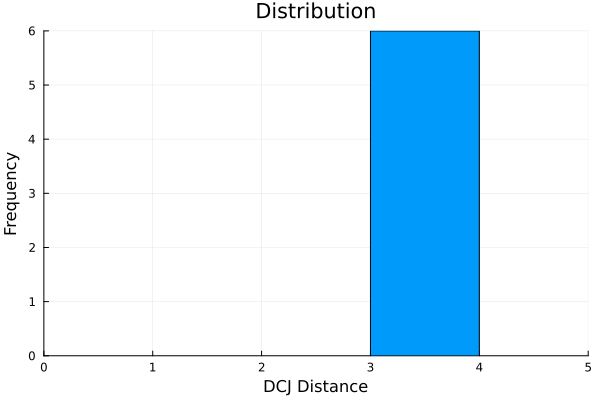

In [8]:
### visualization 

max_value = length(target)+2
println("max dcj distance = ", max_value)

# SOCS of distribution
# shape -- skewed right usually 
# outliers - none 
# center - depends 
# spread -- narrow 
min = minimum(dcj_dist_list)
max = maximum(dcj_dist_list)
avg = mean(dcj_dist_list)

println("min=", min)
println("max=", max)
println("avg=", avg)
println("variability=", max-min)


# range for x-ticks from 0 to max_value with a step of 2
xticks = 0:1:max_value

# Create a histogram
histogram(dcj_dist_list, title="Distribution", label="", xlabel="DCJ Distance", ylabel="Frequency",  xlims=(0, max_value), xticks=(xticks, xticks))

